# Assignment 1 - Dimensionality Reduction using PCA

## Question 1
#### 1. Retrieve and load the mnist_784 dataset of 70,000 instance

In [127]:
from sklearn.datasets import fetch_openml

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
# Get the features and target (images, labels)
X, y = mnist["data"], mnist["target"]

print(X.shape)#Dataset of 70,000

(70000, 784)


#### 2. Display each digit

C:\Users\gcast\AppData\Local\Temp\ipykernel_27220\1812145906.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  unique_digits = df.groupby('label').first()


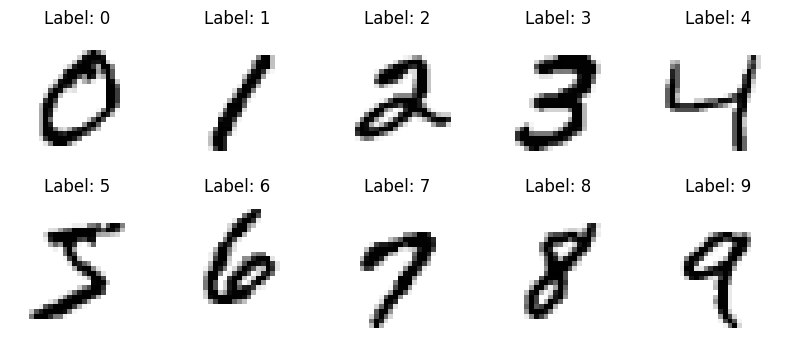

In [128]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame to filter each digit
df = pd.DataFrame(X)
df['label'] = y

#Get the first of each digit (0 through 9)
unique_digits = df.groupby('label').first()

# Plot each row in the unique_digits DataFrame
plt.figure(figsize=(10, 4))

for i, (label, row) in enumerate(unique_digits.iterrows()):
    # Create a subplot in the grid of 2x5 at position i + 1
    plt.subplot(2, 5, i + 1)
    # Plot the row (the image 784px reshaped to 28x28)
    plt.imshow(row.values.reshape(28, 28), cmap="binary")
    # Turn off the axis
    plt.axis("off")
    # Add a title with the label
    plt.title(f"Label: {int(label)}")

# Show the plot
plt.show()

#### 3.Use PCA to retrieve the 1st and 2nd principal components and output their explained variance ratio

In [129]:
from sklearn.decomposition import PCA

# Apply PCA to get the top 2 principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Get the explained variance ratio 
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance ratio of the 1st component: {explained_variance[0]}")
print(f"Explained variance ratio of the 2nd component: {explained_variance[1]}")


Explained variance ratio of the 1st component: 0.09746115922494752
Explained variance ratio of the 2nd component: 0.07155444586878705


#### 4. Plot the projections of the 1st and 2nd principal components onto a 1D hyperplane

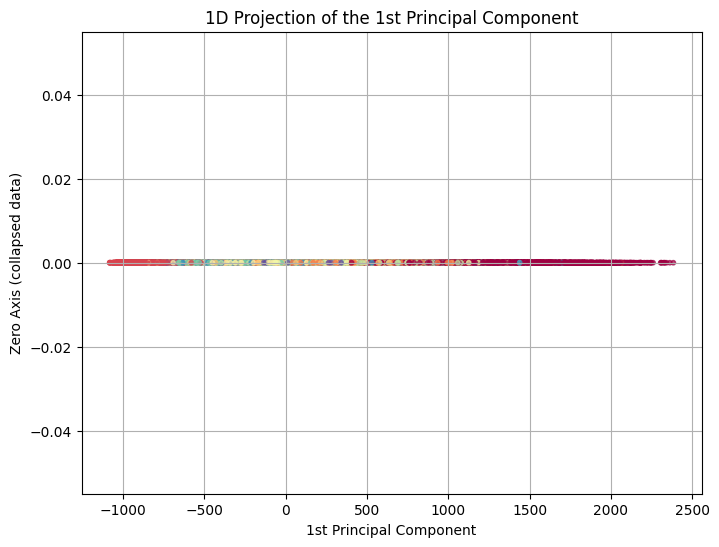

In [130]:
import numpy as np
# Get the first principal component (1D projection)
first_pc_projection = X_pca[:, 0]

# Plot the first principal component
plt.figure(figsize=(8, 6))
# y is a pandas Series with categories
plt.scatter(first_pc_projection, np.zeros_like(first_pc_projection), 
            c=y.cat.codes,  # Convert categorical labels to numeric codes
            cmap="Spectral", s=10, alpha=0.7)
plt.title('1D Projection of the 1st Principal Component')
plt.xlabel('1st Principal Component')
plt.ylabel('Zero Axis (collapsed data)')
plt.grid(True)
plt.show()


5. Use Incremental PCA to reduce the dimensionality of the MNIST dataset down to 154 dimensions

In [131]:
from sklearn.decomposition import IncrementalPCA

# Use Incremental PCA to reduce dimensionality to 154 components
ipca = IncrementalPCA(n_components=154)
X_ipca = ipca.fit_transform(X)

print(X_ipca.shape)


(70000, 154)


#### 6. Display the original and compressed digits from (5)

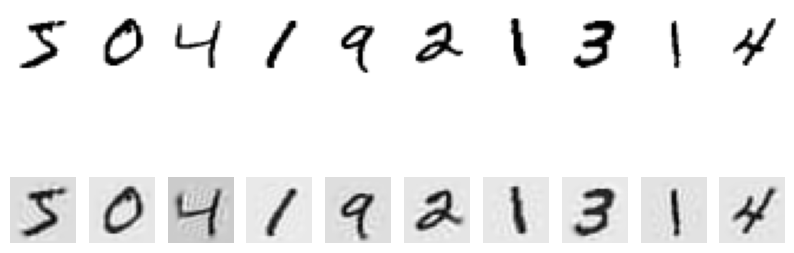

In [132]:
# Reconstruct digits from X_ipca with inverse transformation to get the compressed images
X_ipca_reconstructed = ipca.inverse_transform(X_ipca)

# Plot original and reconstructed digits
plt.figure(figsize=(10, 4))

# Function to plot a single digit image
def plot_digit(image):
    """Function to plot a single digit image."""
    plt.imshow(image.reshape(28, 28), cmap="binary")
    plt.axis("off")


for i in range(10):
    # Original
    plt.subplot(2, 10, i + 1)
    # Turn the row from pandas DataFrame to a Numpy format 
    plot_digit(X.iloc[i].to_numpy())
    
    # Compressed
    plt.subplot(2, 10, i + 11)
    plot_digit(X_ipca_reconstructed[i])
    
plt.show()

7. Create a video discussing the code and result for each question. Discuss challenges you confronted and solutions to overcoming them, if applicable

## Question 2
#### 1. Generate Swiss roll dataset

In [133]:
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt

# Generate 1000 samples of Swiss roll dataset
X, t = make_swiss_roll(n_samples=1000, noise=0.2)

#### 2. Plot the resulting generated Swiss roll dataset

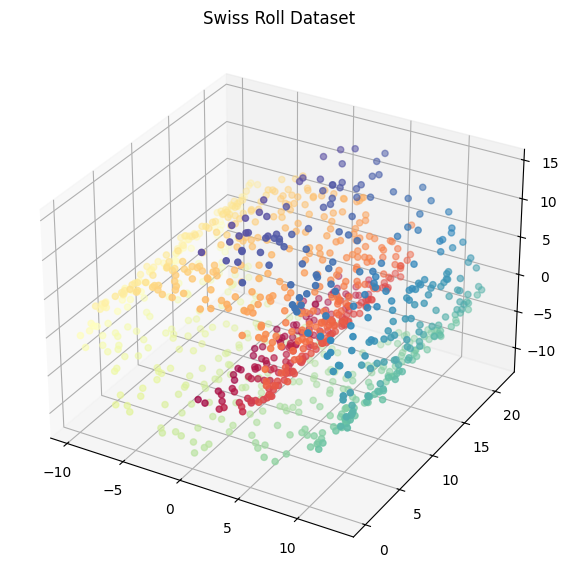

In [134]:
# Plot the Swiss roll dataset
fig = plt.figure(figsize=(10, 7))
# 3d scatter plot 
ax = fig.add_subplot(111, projection='3d')
# Get xyz coordinates from the dataset and color them according to the target
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.get_cmap('Spectral'))
plt.title('Swiss Roll Dataset')
plt.show()

#### 3. Use Kernel PCA (kPCA) with linear, RBF, and sigmoid kernels

In [135]:
from sklearn.decomposition import KernelPCA

# Apply Kernel PCA with linear kernel
kpca_linear = KernelPCA(n_components=2, kernel='linear')
X_kpca_linear = kpca_linear.fit_transform(X)

# Apply Kernel PCA with RBF kernel
kpca_rbf = KernelPCA(n_components=2, kernel='rbf', gamma=0.04)
X_kpca_rbf = kpca_rbf.fit_transform(X)

# Apply Kernel PCA with sigmoid kernel
kpca_sigmoid = KernelPCA(n_components=2, kernel='sigmoid', gamma=0.001, coef0=1)
X_kpca_sigmoid = kpca_sigmoid.fit_transform(X)


#### 4. Plot the kPCA results of applying the linear, RBF, and sigmoid kernels

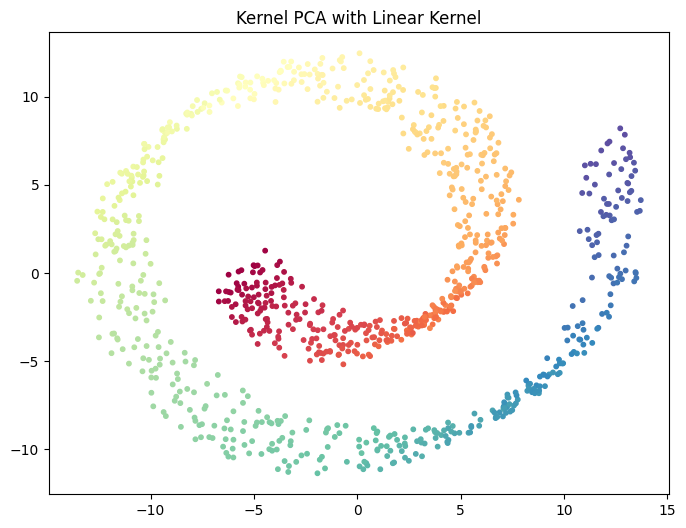

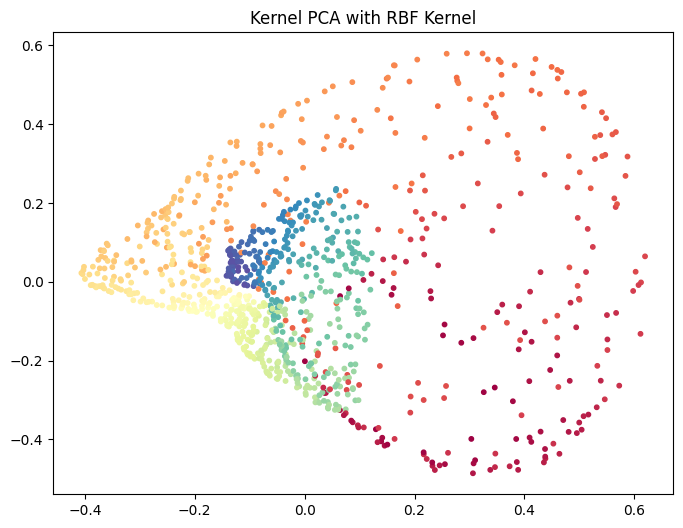

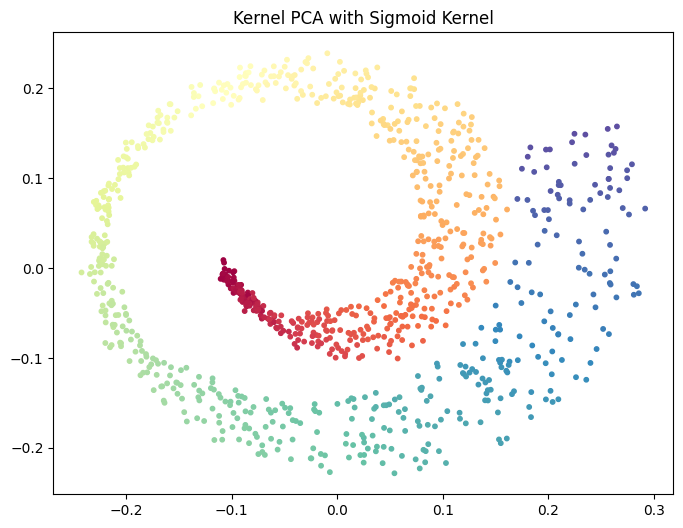

In [136]:
# Function to plot the results
def plot_kpca(X_transformed, title):
    plt.figure(figsize=(8, 6))
    # Scatter plot of the 2D projection with x and y coordinates of the transformed data
    plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=t, cmap="Spectral", s=10)
    plt.title(title)
    plt.show()

# Plot projections
plot_kpca(X_kpca_linear, "Kernel PCA with Linear Kernel")
plot_kpca(X_kpca_rbf, "Kernel PCA with RBF Kernel")
plot_kpca(X_kpca_sigmoid, "Kernel PCA with Sigmoid Kernel")


#### 5. Using kPCA and a kernel of your choice, apply Logistic Regression for classification. Use GridSearchCV to find the best kernel and gamma value for kPCA in order to get the best classification accuracy at the end of the pipeline. Print out best parameters found by GridSearchCV

In [137]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Convert continuous target to discrete classes
# Create discrete labels by binning the color values
# Here we create 3 classes based on quantiles
t = np.digitize(t, bins=np.quantile(t, [0, 0.33, 0.66, 1.0]))

# Standardizing the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the pipeline
pipeline = Pipeline([
    ('kpca', KernelPCA(n_components=2)),
    ('logistic', LogisticRegression(max_iter=1000))  # Increase max_iter if needed
])

# Define the parameter grid
param_grid = {
    'kpca__kernel': ['linear', 'rbf', 'sigmoid'],
    'kpca__gamma': np.linspace(0.03, 0.05, 10),
}

# Perform GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_scaled, t)

# Print best parameters
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)


c:\Users\gcast\anaconda3\envs\tf_env\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best parameters found by GridSearchCV:
{'kpca__gamma': 0.03, 'kpca__kernel': 'linear'}


6. Plot the results from using GridSearchCV

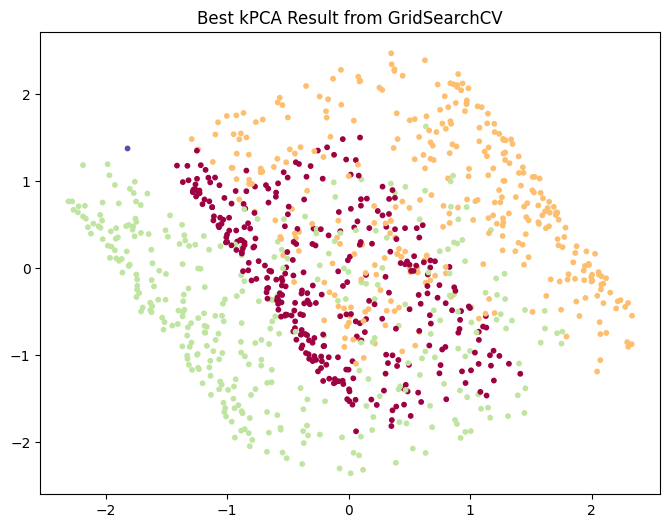

In [138]:
# Accessing the best KernelPCA instance
best_kpca = grid_search.best_estimator_.named_steps['kpca']

# Transform the original dataset X using the best kPCA instance
X_best_kpca = best_kpca.transform(X_scaled)

# Plot the transformed data
plot_kpca(X_best_kpca, "Best kPCA Result from GridSearchCV")